## **Imports**

In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import pygame
from gym import Env
from gym.spaces import Discrete, Box
import matplotlib.pyplot as plt
from IPython.display import Image, display

# **Building Custom Maze Environment**

In [16]:
class CustomMazeEnv(Env):
    def __init__(self):
        super().__init__()
        self.maze = np.array([
            [1,1,1,1,1,1,1,1,1,1,1,1,1,1],
            [1,3,0,2,0,1,0,0,0,0,0,0,0,1],
            [1,0,0,0,0,1,1,1,1,0,0,1,0,1],
            [1,0,0,0,0,0,0,0,1,0,0,1,0,1],
            [1,1,1,1,0,1,1,0,0,0,0,1,1,1],
            [1,0,0,1,0,1,0,0,0,2,0,1,0,4],
            [1,0,0,0,0,1,0,0,0,0,0,1,0,1],
            [1,0,2,0,0,1,1,1,1,1,1,1,0,1],
            [1,0,0,0,0,1,0,0,0,0,0,1,0,1],
            [1,0,0,1,0,1,0,0,0,0,1,1,0,1],
            [1,0,0,1,0,1,0,2,0,0,0,0,0,1],
            [1,0,0,1,1,1,0,2,0,0,2,2,0,1],
            [1,0,0,0,0,0,0,2,0,0,2,0,0,1],
            [1,0,0,0,0,0,0,0,0,0,0,0,0,1],
            [1,1,1,1,1,1,1,1,1,1,1,1,1,1]
        ])
        self.start_pos = np.argwhere(self.maze == 3)[0]
        self.goal_pos  = np.argwhere(self.maze == 4)[0]
        self.agent_pos = self.start_pos.copy()
        self.action_space = Discrete(4)  # 0:left, 1:right, 2:up, 3:down
        self.observation_space = Box(
            low=np.array([0,0]),
            high=np.array([self.maze.shape[0]-1, self.maze.shape[1]-1]),
            dtype=np.int32
        )
        pygame.init()
        self.cell_size = 40
        self.screen = pygame.display.set_mode((
            self.maze.shape[1]*self.cell_size,
            self.maze.shape[0]*self.cell_size
        ))
        pygame.display.set_caption("Custom Maze Environment")

    def reset(self):
        self.agent_pos = self.start_pos.copy()
        return np.array(self.agent_pos, dtype=np.int32)

    def step(self, action):
        x, y = self.agent_pos
        new_pos = [x, y]
        if   action == 0: new_pos[1] -= 1
        elif action == 1: new_pos[1] += 1
        elif action == 2: new_pos[0] -= 1
        elif action == 3: new_pos[0] += 1


        if not (0 <= new_pos[0] < self.maze.shape[0] and
                0 <= new_pos[1] < self.maze.shape[1]):
            return np.array(self.agent_pos, dtype=np.int32), -10, False, {}

        cell = self.maze[new_pos[0], new_pos[1]]
        if cell == 1:
            reward, done = -10, False
        else:
            self.agent_pos = new_pos
            if (new_pos[0], new_pos[1]) == tuple(self.goal_pos):
                reward, done = 100, True
            elif cell == 2:
                reward, done = -20, False
            else:
                reward, done = 5, False

        return np.array(self.agent_pos, dtype=np.int32), reward, done, {}

    def render(self, save_as_image=False, image_path="maze_image.png"):
        self.screen.fill((255,255,255))
        colors = {0:(255,255,255), 1:(0,0,0), 2:(255,0,0), 3:(0,255,0), 4:(0,0,255)}
        for r in range(self.maze.shape[0]):
            for c in range(self.maze.shape[1]):
                pygame.draw.rect(
                    self.screen, colors[self.maze[r,c]],
                    (c*self.cell_size, r*self.cell_size, self.cell_size, self.cell_size)
                )
                pygame.draw.rect(
                    self.screen, (0,0,0),
                    (c*self.cell_size, r*self.cell_size, self.cell_size, self.cell_size), 1
                )
        pygame.draw.circle(
            self.screen, (255,255,0),
            (self.agent_pos[1]*self.cell_size + self.cell_size//2,
             self.agent_pos[0]*self.cell_size + self.cell_size//2),
            self.cell_size//3
        )
        pygame.display.flip()
        if save_as_image:
            pygame.image.save(self.screen, image_path)
            print(f"Saved: {image_path}")

    def close(self):
        pygame.quit()


# **Q-Network Definition**

In [17]:
class QNetwork(nn.Module):
    def __init__(self, in_size, out_size, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_size, hidden),
            nn.ReLU(),
            nn.Linear(hidden, out_size)
        )

    def forward(self, x):
        return self.net(x)


# **Replay Buffer**

In [18]:
class ReplayBuffer:
    def __init__(self, cap=10000):
        self.buf = deque(maxlen=cap)

    def push(self, s, a, r, s_next, d):
        self.buf.append((s, a, r, s_next, d))

    def sample(self, bs):
        batch = random.sample(self.buf, bs)
        s, a, r, s_next, d = zip(*batch)
        return (
            np.array(s),
            np.array(a),
            np.array(r, dtype=np.float32),
            np.array(s_next),
            np.array(d, dtype=np.uint8)
        )

    def __len__(self):
        return len(self.buf)


# **DQN Agent**

In [19]:
class DQNAgent:
    def __init__(
        self,
        state_size=2,
        action_size=4,
        lr=0.001,
        gamma=0.9,
        eps_start=1.0,
        eps_end=0.01,
        episodes=100,
        bs=32,
        cap=10000
    ):
        self.state_size, self.action_size, self.gamma = state_size, action_size, gamma
        self.episodes, self.bs = episodes, bs
        self.eps_start, self.eps_end = eps_start, eps_end
        self.net = QNetwork(state_size, action_size)
        self.opt = optim.Adam(self.net.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()
        self.buf = ReplayBuffer(cap)

    def eps(self, ep):
        return self.eps_start * (self.eps_end/self.eps_start)**(ep/self.episodes)

    def get_action(self, s, ep):
        if random.random() < self.eps(ep):
            return random.randint(0, self.action_size-1)
        with torch.no_grad():
            q = self.net(torch.FloatTensor(s).unsqueeze(0))
        return int(torch.argmax(q).item())

    def update(self):
        if len(self.buf) < self.bs:
            return
        s, a, r, s_next, d = self.buf.sample(self.bs)
        s       = torch.FloatTensor(s)
        a       = torch.LongTensor(a).unsqueeze(1)
        r       = torch.FloatTensor(r).unsqueeze(1)
        s_next  = torch.FloatTensor(s_next)
        d       = torch.FloatTensor(d).unsqueeze(1)

        q_curr = self.net(s).gather(1, a)
        with torch.no_grad():
            q_next = self.net(s_next).max(1)[0].unsqueeze(1)
        target = r + self.gamma * q_next * (1 - d)

        loss = self.loss_fn(q_curr, target)
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()


# **Training & Evaluation**

In [20]:
def run_episode(agent, env, ep, train=True, max_steps=10000):
    s = env.reset()
    total, steps = 0, 0
    done = False
    while not done and steps < max_steps:
        a = agent.get_action(s, ep)
        s_next, r, done, _ = env.step(a)
        total += r
        steps += 1
        if train:
            agent.buf.push(s, a, r, s_next, done)
            agent.update()
        s = s_next
    return total, steps, done

def evaluate(agent, env, episodes=20, max_steps=10000):
    rewards, successes = [], 0
    for _ in range(episodes):
        r, steps, done = run_episode(agent, env, ep=0, train=False, max_steps=max_steps)
        rewards.append(r)
        if done:
            successes += 1
    avg_reward = np.mean(rewards)
    success_rate = successes / episodes * 100
    return avg_reward, success_rate


# **Execution and Visualization**

متاهة أولية:
Saved: maze_initial.png


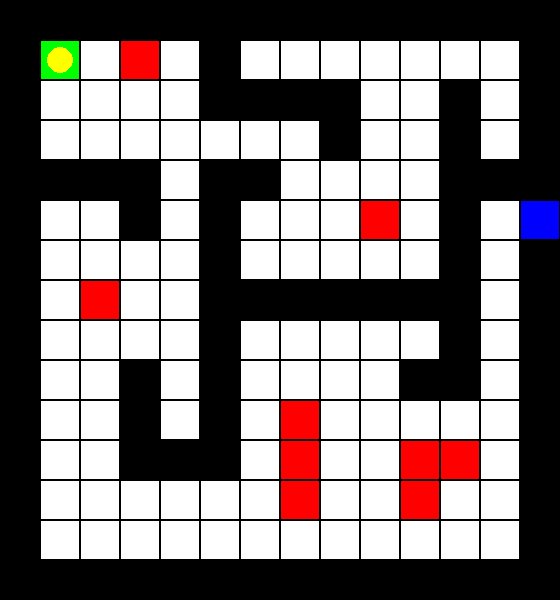

Ep 10: Total Reward=22485, Steps=10000
Ep 20: Total Reward=6045, Steps=10000
Ep 30: Total Reward=30215, Steps=10000
Ep 40: Total Reward=42990, Steps=10000
Ep 50: Total Reward=44975, Steps=10000
Ep 60: Total Reward=46745, Steps=10000
Ep 70: Total Reward=48480, Steps=10000
Ep 80: Total Reward=48485, Steps=10000
Ep 90: Total Reward=49225, Steps=10000
Ep 100: Total Reward=49540, Steps=10000


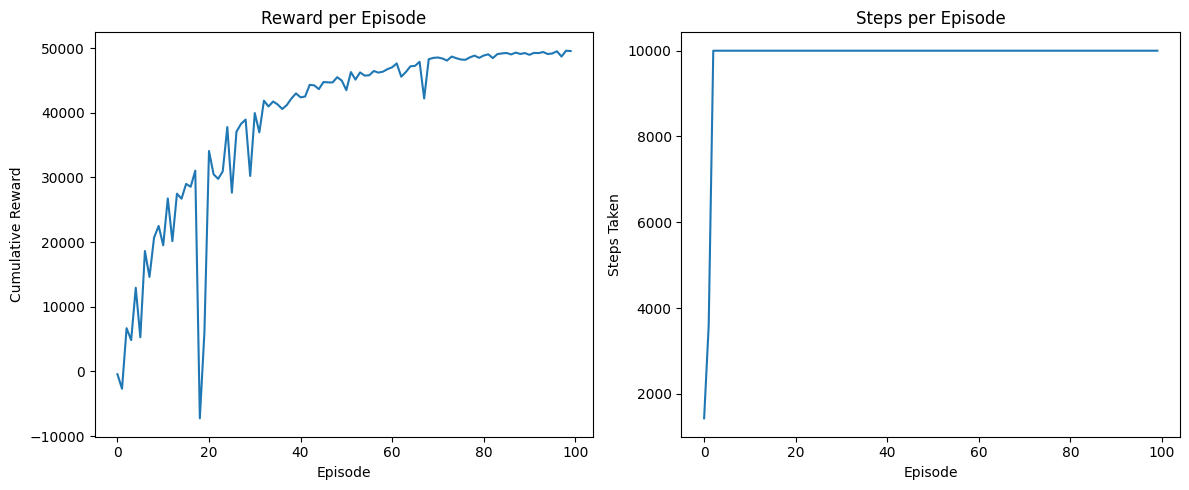


تقييم الموديل: متوسط المكافأة = -2919.00، نسبة النجاح = 85.0%
متاهة بعد التدريب:
Saved: maze_final.png


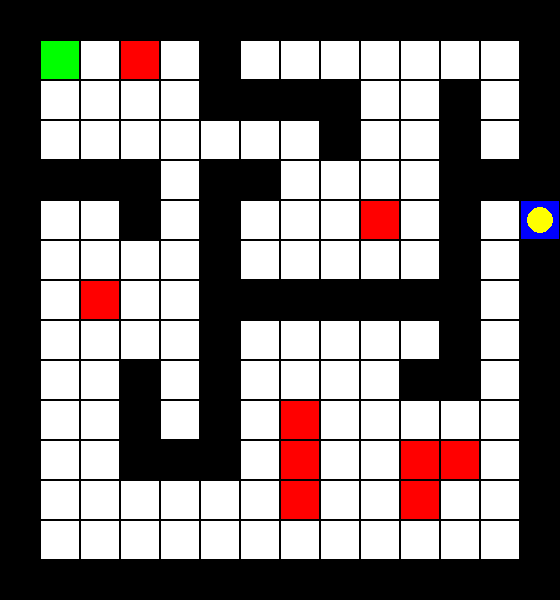

In [23]:
if __name__ == "__main__":
    env   = CustomMazeEnv()
    agent = DQNAgent(episodes=100)

    print("متاهة أولية:")
    env.render(save_as_image=True, image_path="maze_initial.png")
    display(Image(filename="maze_initial.png"))

    rewards_list, steps_list = [], []
    for ep in range(agent.episodes):
        total, steps, _ = run_episode(agent, env, ep, train=True)
        rewards_list.append(total)
        steps_list.append(steps)
        if (ep+1) % 10 == 0:
            print(f"Ep {ep+1}: Total Reward={total}, Steps={steps}")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(rewards_list)
    plt.xlabel("Episode"); plt.ylabel("Cumulative Reward"); plt.title("Reward per Episode")
    plt.subplot(1, 2, 2)
    plt.plot(steps_list)
    plt.xlabel("Episode"); plt.ylabel("Steps Taken");     plt.title("Steps per Episode")
    plt.tight_layout(); plt.show()


    avg_reward, success_rate = evaluate(agent, env)
    print(f"\nتقييم الموديل: متوسط المكافأة = {avg_reward:.2f}، نسبة النجاح = {success_rate:.1f}%")


    print("متاهة بعد التدريب:")
    env.render(save_as_image=True, image_path="maze_final.png")
    display(Image(filename="maze_final.png"))


In [24]:
    model_path = "dqn_maze.pth"
    torch.save(agent.net.state_dict(), model_path)
    print(f"Model saved to {model_path}")

Model saved to dqn_maze.pth
